In [6]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import time 
import cmath

In [74]:
class BP_synthesis(object):
    
    def __init__(self,   wavelength, 
                 holo_size, 
                 reshaped_img_coord_x,
                 reshaped_img_coord_y,
                 near_zone = True,
                 distance = None,
                 img_size_for_syn = None,
                 holo_pixel_size = None
                ):
        self.name = 'Bipolar_intensity'
        self.near_zone = near_zone
        self.holo_size = holo_size
        self.distance = distance
        self.wavelength = wavelength
        self.reshaped_img_coord_x = reshaped_img_coord_x
        self.reshaped_img_coord_y = reshaped_img_coord_y 
        self.error_list = []
        
        if near_zone:
            self._first_frenel_factor = None
            self._second_frenel_factor = None
            self._first_inv_frenel_factor = None
            self._second_inv_frenel_factor = None
            self.holo_pixel_size =  holo_pixel_size
            self.scale = self.wavelength * self.distance / (self.holo_size * self.holo_pixel_size**2)
        
        if img_size_for_syn  is None:
            self.img_size_for_syn = self.holo_size - int(self.holo_size/2)
        else: self.img_size_for_syn = img_size_for_syn
            
            
    def reshape_img_for_syn(self, input_matrix):
        new_img = np.zeros((self.holo_size, self.holo_size)) 
        reshape_img = cv2.resize(input_matrix, (self.img_size_for_syn,self.img_size_for_syn))
        self.reshape_img = reshape_img
        new_img[
                self.reshaped_img_coord_y:self.reshaped_img_coord_y + self.img_size_for_syn, 
                self.reshaped_img_coord_x:self.reshaped_img_coord_x + self.img_size_for_syn
                ] = reshape_img
        self.new_img = new_img 
        return new_img  
        
    
    @property
    def first_frenel_factor(self):
        if self._first_frenel_factor is None and self.near_zone:
            self._first_frenel_factor = (
                np.exp(
                    np.array([
                        [
                            1j * np.pi * self.scale * ((i- int(self.holo_size / 2))**2 + (j - int(self.holo_size / 2))**2) / self.holo_size
                            for j in range(self.holo_size)
                        ]
                        for i in range(self.holo_size)
                    ])
                )
            ) 

        return self._first_frenel_factor

    @property
    def second_frenel_factor(self):
        if self._second_frenel_factor is None and self.near_zone:
            self._second_frenel_factor = (
                np.exp(
                    np.array([
                        [
                            1j * np.pi * ((i- int(self.holo_size / 2))**2 + (j - int(self.holo_size / 2))**2) / (self.holo_size * self.scale)
                                   for j in range(self.holo_size)
                        ] 
                        for i in range(self.holo_size)
                    ])
                )
            )
        return self._second_frenel_factor
    
    @property
    def first_inv_frenel_factor(self):
        if self._first_inv_frenel_factor is None and self.near_zone:
            self._first_inv_frenel_factor = np.exp(
                np.array([
                    [
                        -1j * np.pi * ((i- int(self.holo_size / 2))**2 + (j - int(self.holo_size / 2))**2)/(self.scale * self.holo_size)
                        for j in range(self.holo_size)
                    ]
                    for i in range(self.holo_size)
                ])
            )
        return self._first_inv_frenel_factor

    @property
    def second_inv_frenel_factor(self):
        if self._second_inv_frenel_factor is None and self.near_zone:
            self._second_inv_frenel_factor = np.exp(
                np.array([
                    [
                        -1j * np.pi * self.scale *  ((i - int(self.holo_size / 2))**2 + (j - int(self.holo_size / 2))**2) / (self.holo_size)
                        for j in range(self.holo_size)
                    ]
                    for i in range(self.holo_size)
                ])
            )
            

        return self._second_inv_frenel_factor
    
    def frenel_transform(self,input_matrix):
        fourier = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(input_matrix * self.first_frenel_factor)))
        return  self.second_frenel_factor * fourier
    
    def inverse_frenel_transform(self,input_matrix):
        inv_fourier = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(input_matrix * self.first_inv_frenel_factor)))
        return self.second_inv_frenel_factor * inv_fourier
    
    def fourier_transform(self,input_matrix):
        return np.fft.ifftshift(np.fft.fft2(np.fft.ifftshift(input_matrix)))
    
    def inverse_fourier_transform(self,input_matrix):
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(input_matrix)))
    
    def del_central_zone(self,input_matrix):
        central_point = int(self.holo_size / 2)
        input_matrix[central_point - 1:central_point + 1, central_point - 1:central_point + 1] = 0
        return input_matrix
    
    def img_recovery(self, holo):
        if self.near_zone:
            rec_img = abs(self.inverse_frenel_transform(self.prepare_for_transform(holo)))
            rec_img = self.del_central_zone(rec_img)
            plt.plot(rec_img)
            plt.show()
            plt.imshow(rec_img, cmap = 'gray')
            plt.show()
            cv2.imwrite("C:\\Users\\minik\\Desktop\\10.bmp",rec_img*255/rec_img.max())
        else:
            rec_img = abs(self.fourier_transform(self.prepare_for_transform(holo)))
            rec_img = self.del_central_zone(rec_img)
            plt.plot(rec_img)
            plt.show()
            plt.imshow(rec_img, cmap = 'gray')
            plt.show()
        self.recovery_img  = rec_img   
        informative_img_zone = rec_img [
                                    self.reshaped_img_coord_y:self.reshaped_img_coord_y + self.img_size_for_syn, 
                                    self.reshaped_img_coord_x:self.reshaped_img_coord_x + self.img_size_for_syn
            
                                    ]
        
        self.informative_img_zone = informative_img_zone
    
    
    def matrix_normalization(self, input_matrix):
        norm_matrix = np.zeros((self.holo_size, self.holo_size)) 
        for i in range (self.holo_size):
            for j in range (self.holo_size):
                element = cmath.phase(input_matrix[i,j])
                if element < 0:
                    element = 2 * np.pi + element
                element = element/(2 * np.pi) * 256
                norm_matrix[i,j] = element
        return norm_matrix.astype('uint8')
    
    def prepare_for_transform (self, input_matrix):
        return np.exp(1j * input_matrix * 2 * np.pi / 255)
    
    def calc_error(self, input_matrix, real_img):
        input_matrix = np.float64(abs(input_matrix))
        real_img = np.float64(abs(real_img))
        a = np.sum(input_matrix**2)
        b = np.sum(real_img**2)
        ab = np.sum(input_matrix*real_img)
        return np.sqrt(1-(ab*ab)/(a*b))
       
    def phase_mask(self, input_matrix):
        mask = np.int8(np.random.rand(self.holo_size,self.holo_size) * 2)       
        return input_matrix * np.exp(1j * np.pi * mask)    
    
    def __call__(self, input_matrix):
        start_time = time.time()
        img = self.reshape_img_for_syn(input_matrix)
        img  = self.phase_mask(img)
        if self.near_zone:
            holo = self.frenel_transform(img)
        else :
            holo = self.fourier_transform(img)
        holo = 2 * (np.real(holo) - np.real(holo).min())
        holo = np.uint8(holo * 255 /holo.max())
        self.img_recovery(holo)
        error = self.calc_error( self.informative_img_zone, self.reshape_img)
        print("Error ", error)
        
        self.error_list.append(error)
        print("Time --- %s seconds ---" % (time.time() - start_time))
        self.holo  = holo
        return holo
            
        
            
        
    
    
    
    
    
    
    

In [75]:
def show (class_obj, informative_img_zone = True, holo = False):
    pic_box = plt.figure(figsize=(12, 6))
    if holo:
        ax = pic_box.add_subplot(1,1,1)
        ax.set_title("Holo")
        ax.imshow(class_obj.holo, cmap = 'gray')
    else:   
        if informative_img_zone:
            if class_obj.name == 'Bipolar_intensity':
                plt.suptitle("NSTD = " + str(class_obj.error_list[-1]))
            else:
                plt.suptitle("NSTD = " + str(class_obj.error_list[-1][-1]))

            ax1 = pic_box.add_subplot(1,2,1)
            ax1.set_title("Real image")
            ax1.imshow(class_obj.reshape_img, cmap = 'gray')

            ax2 = pic_box.add_subplot(1,2,2)
            ax2.set_title('Reconstructed image')
            ax2.imshow(class_obj.informative_img_zone,cmap = 'gray')
            
        else:
            if class_obj.name == 'Bipolar_intensity':
                plt.suptitle("NSTD = " + str(class_obj.error_list[-1]))
            else:
                plt.suptitle("NSTD = " + str(class_obj.error_list[-1][-1]))

            ax1 = pic_box.add_subplot(1,2,1)
            ax1.set_title("Real image")
            ax1.imshow(class_obj.new_img, cmap = 'gray')

            ax2 = pic_box.add_subplot(1,2,2)
            ax2.set_title('Reconstructed image')
            ax2.imshow(class_obj.recovery_img, cmap = 'gray')
           
        
    plt.show()
    
    

In [76]:
def save_holo(filename, holo):
    cv2.imwrite(filename,holo)
    

In [77]:
transform = BP_synthesis(
    wavelength = 532e-9,
    holo_size = 1024,
    img_size_for_syn = 256,
    near_zone = True,
    reshaped_img_coord_x = 200,
    reshaped_img_coord_y = 200,
    distance = 0.7,
    holo_pixel_size = 8e-6
    
)

In [78]:
img_2 = cv2.imread("C:\\Users\\minik\\Desktop\\timur1.jpg", cv2.IMREAD_GRAYSCALE)
img_1 = cv2.imread("C:\\Users\\minik\\Desktop\\monro.jpg", cv2.IMREAD_GRAYSCALE)

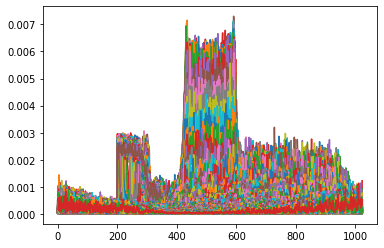

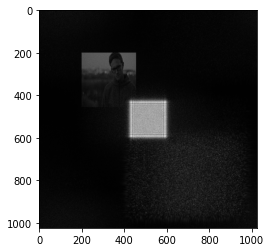

Error  0.3874961011251897
Time --- 5.851210594177246 seconds ---


In [79]:
holo = transform(img_2)

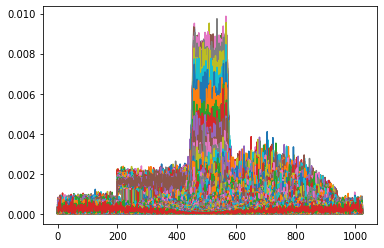

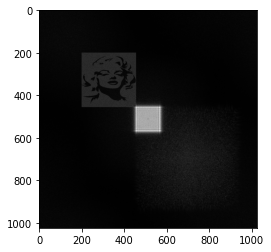

Error  0.1465912711896186
Time --- 1.9727225303649902 seconds ---


In [64]:
holo_2 = transform(img_1)